# The TrafficMC Object

[trafficmc.py](trafficmc.py)

In [6]:
import trafficmc

In [33]:
mc = trafficmc.TrafficMC(1000, 300, 6, 1/3)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

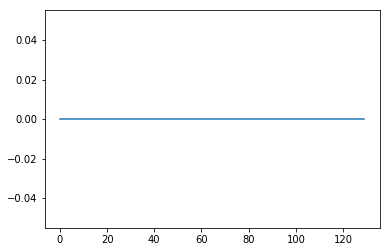

In [33]:
plt.plot(mc.v)

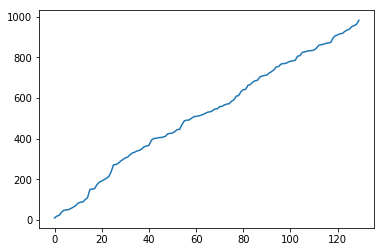

In [34]:
plt.plot(mc.x)

# Thermalization

In [34]:
vs = []
for _ in range(300):
    vs.append(mc.v.mean())
    mc.step()

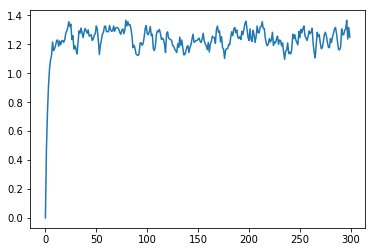

In [45]:
plt.plot(vs)

In [14]:
def therm(x, N):
    for _ in range(N):
        x.step()
    return x

# Simulation and Measurements

In [2]:
[i**2 for i in range(10)]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [3]:
{i: i**2 for i in range(10)}

{0: 0, 1: 1, 2: 4, 3: 9, 4: 16, 5: 25, 6: 36, 7: 49, 8: 64, 9: 81}

In [35]:
def sim(mc, N, **fns):
    measurements = {k: [] for k in fns}
    for _ in range(N):
        mc.step()
        for k in fns:
            measurements[k].append(fns[k](mc))
    return measurements

In [40]:
results = sim(mc, 1000, x = lambda mc: mc.x.copy())

In [40]:
import numpy as np

In [38]:
def viz_sim(res, N, ax=None):
    if not ax:
        ax = plt.gca()
    im = np.zeros((len(res['x']), N))
    for i, xs in enumerate(res['x']):
        for x in xs:
            im[i, x] = 1
    plt.imshow(im, cmap='binary')
    plt.xlabel('distance on road')
    plt.ylabel('simulation time')

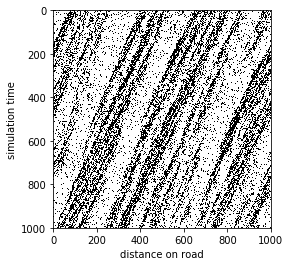

In [41]:
viz_sim(results, mc.N)

# Doing Spark

In [4]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

In [5]:
sc = SparkContext('local[4]')

In [8]:
spark = SQLContext(sc)

# Vehicle Miles Traveled - Uniform Driving Ability

In [20]:
mcs = (sc.parallelize([(1000, 120, 6, 1/3) for _ in range(500)])
         .map(lambda x: trafficmc.TrafficMC(*x)))

In [21]:
mcs = mcs.map(lambda x: therm(x, 1000))

In [22]:
results = (mcs.map(lambda mc: sim(mc, 1000, x = lambda mc: mc.v.sum()))
              .map(lambda res: Row(dist = float(sum(res['x'])) / 1000)))

In [23]:
results.take(5)

[Row(dist=437.09),
 Row(dist=441.711),
 Row(dist=438.226),
 Row(dist=442.944),
 Row(dist=450.331)]

In [24]:
df = spark.createDataFrame(results).toPandas()

In [25]:
df.head()

,dist
0,437.090
1,441.711
2,438.226
3,442.944
4,450.331


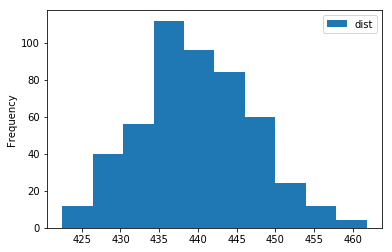

In [26]:
df.plot.hist('dist', bins = 10)

# Uniformly Distributed Driving

In [28]:
import numpy as np

In [29]:
mcs = (sc.parallelize([(1000, 120, 6, np.random.uniform(0, 0.5, 120)) for _ in range(500)])
         .map(lambda x: trafficmc.TrafficMC(*x)))
mcs = mcs.map(lambda x: therm(x, 1000))

In [30]:
results = (mcs.map(lambda mc: sim(mc, 1000, x = lambda mc: mc.v.sum()))
              .map(lambda res: Row(dist = float(sum(res['x'])) / 1000)))
df = results.toDF().toPandas()

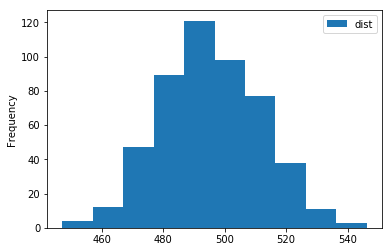

In [31]:
df.plot.hist('dist', bins = 10)

In [32]:
sc.stop()